PREPARING FOR THE PROJECT

In [23]:
import torch
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import os

BATCH_SIZE = 40
NUM_WORKERS = 8
IMAGE_SIZE = (224, 224)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [24]:
path = {
    x: os.path.join('images', x) for x in ['train', 'valid', 'test']
}

IMAGE PREPROCESSING AND VISUALIZING

In [25]:
train_transforms = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    transforms.RandomHorizontalFlip(0.7),
    transforms.RandomVerticalFlip(0.4),
    transforms.RandomRotation(30),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

valid_trainsforms = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

In [26]:
train_dataset = datasets.ImageFolder(path['train'], transform=train_transforms)
valid_dataset = datasets.ImageFolder(path['valid'], transform=valid_trainsforms)
test_dataset = datasets.ImageFolder(path['test'], transform=valid_trainsforms)

class_name = train_dataset.classes
class_name

['ADONIS',
 'AFRICAN GIANT SWALLOWTAIL',
 'AMERICAN SNOOT',
 'AN 88',
 'APPOLLO',
 'ARCIGERA FLOWER MOTH',
 'ATALA',
 'ATLAS MOTH',
 'BANDED ORANGE HELICONIAN',
 'BANDED PEACOCK',
 'BANDED TIGER MOTH',
 'BECKERS WHITE',
 'BIRD CHERRY ERMINE MOTH',
 'BLACK HAIRSTREAK',
 'BLUE MORPHO',
 'BLUE SPOTTED CROW',
 'BROOKES BIRDWING',
 'BROWN ARGUS',
 'BROWN SIPROETA',
 'CABBAGE WHITE',
 'CAIRNS BIRDWING',
 'CHALK HILL BLUE',
 'CHECQUERED SKIPPER',
 'CHESTNUT',
 'CINNABAR MOTH',
 'CLEARWING MOTH',
 'CLEOPATRA',
 'CLODIUS PARNASSIAN',
 'CLOUDED SULPHUR',
 'COMET MOTH',
 'COMMON BANDED AWL',
 'COMMON WOOD-NYMPH',
 'COPPER TAIL',
 'CRECENT',
 'CRIMSON PATCH',
 'DANAID EGGFLY',
 'EASTERN COMA',
 'EASTERN DAPPLE WHITE',
 'EASTERN PINE ELFIN',
 'ELBOWED PIERROT',
 'EMPEROR GUM MOTH',
 'GARDEN TIGER MOTH',
 'GIANT LEOPARD MOTH',
 'GLITTERING SAPPHIRE',
 'GOLD BANDED',
 'GREAT EGGFLY',
 'GREAT JAY',
 'GREEN CELLED CATTLEHEART',
 'GREEN HAIRSTREAK',
 'GREY HAIRSTREAK',
 'HERCULES MOTH',
 'HUMMING BIRD H

In [27]:
torch.manual_seed(26)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.4831376].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.3959913].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.2489083].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping inp

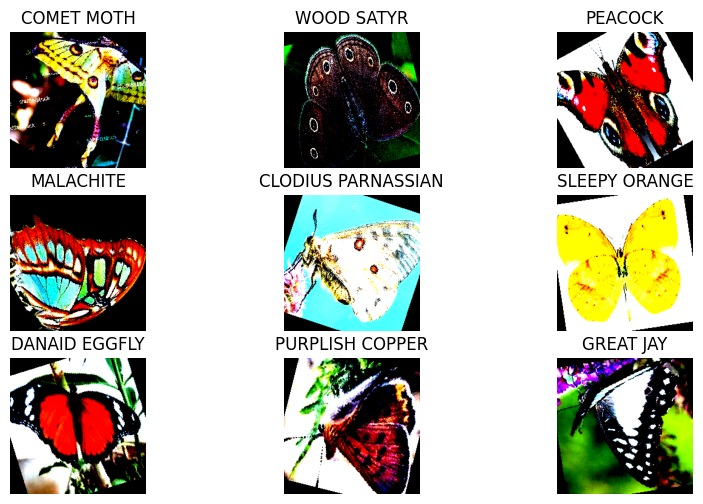

In [28]:
img_batch, label_batch = next(iter(train_dataloader))


fig, axes = plt.subplots(3, 3, figsize=(10, 6))

for i in range(9):
    ax = axes[i//3, i%3]
    ax.imshow(img_batch[i].permute(1, 2, 0))
    ax.axis('off')
    ax.set_title(class_name[label_batch[i]])

CREATING FUNCTIONS FOR TRAINNING AND VALIDATING

In [29]:
import torch.nn as nn
import torch.optim as optim

def train_model(model: nn.Module, dataloader: DataLoader, loss_fn: nn.Module, optimizer: optim.Optimizer, scheduler: optim.lr_scheduler = None):
    loss, acc = 0, 0
    
    model.train()
    
    for img_batch, label_batch in dataloader:
        img_batch, label_batch = img_batch.to(device), label_batch.to(device)
        output = model(img_batch)
        loss_batch = loss_fn(output, label_batch)
        
        loss += loss_batch.item()
        
        optimizer.zero_grad()
        loss_batch.backward()
        optimizer.step()
        
        final_output = torch.argmax(torch.softmax(output, dim=1), dim=1)
        acc += ((final_output == label_batch).sum().item() / len(label_batch))
        
    acc = acc / len(dataloader)
    loss = loss / len(dataloader)
    if scheduler is not None:
        scheduler.step()
    
    return acc, loss

In [30]:
def valid_model(model: nn.Module, dataloader: DataLoader, loss_fn: nn.Module):
    loss, acc = 0, 0
    
    model.eval()
    
    with torch.inference_mode():
        for img_batch, label_batch in dataloader:
            img_batch, label_batch = img_batch.to(device), label_batch.to(device)
            output = model(img_batch)
            loss_batch = loss_fn(output, label_batch)
            
            loss += loss_batch.item()
            
            final_output = torch.argmax(torch.softmax(output, dim=1), dim=1)
            acc += ((final_output == label_batch).sum().item() / len(label_batch))
            
    acc = acc / len(dataloader)
    loss = loss / len(dataloader)
    
    return acc, loss

In [31]:
from tqdm import tqdm

def start_train(model: nn.Module, train_dataloader: DataLoader, valid_dataloader: DataLoader, loss_fn: nn.Module, optimizer: optim.Optimizer, scheduler: optim.lr_scheduler = None, epochs: int = 15):
    
    # variables for record results
    history_acc = {
        'train': [],
        'valid': []
    }
    
    history_loss = {
        'train': [],
        'valid': []
    }
    
    overfit_counter = 0 # for early stopping if model overfits
    
    for epoch in range(epochs):
        with tqdm(total=2, desc=f'Epoch: {epoch+1}/{epochs}') as pbar:
            train_acc, train_loss = train_model(model, train_dataloader, loss_fn, optimizer, scheduler)
            pbar.update()
            valid_acc, valid_loss = valid_model(model, valid_dataloader, loss_fn)
            pbar.update()
        pbar.clear()
        
        history_acc['train'].append(train_acc)
        history_acc['valid'].append(valid_acc)
        
        history_loss['train'].append(train_loss)
        history_loss['valid'].append(valid_loss)
        
        print(f'\ttrain acc: {train_acc*100:.3f}% | train loss: {train_loss:.3f} -------------- valid acc: {valid_acc*100:.3f}% | valid loss: {valid_loss:.3f}')
        
        
        # model will stop if train accuracy reaches 99% or valid accuracy doesnt increase after 3 epochs
        if train_acc >= 0.99:
            break
        
        if len(history_acc['valid']) > 2  and abs(valid_acc - history_acc['valid'][-2]) <= 0.001:
            overfit_counter += 1
        else: 
            overfit_counter = 0
            
        if overfit_counter == 3:
            print('Early stop!')
            break
        
    return history_acc, history_loss
    

FINE-TUNING PRETRAINED MODEL - Resnet18

In [32]:
from torchvision.models import resnet18, ResNet18_Weights

model = resnet18(weights=ResNet18_Weights.DEFAULT)

model.fc = nn.Linear(model.fc.in_features, len(class_name))

model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [33]:
multi_step = [9, 15, 19, 23]

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4) #small weight decay to reduce overfitting
lr_scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=multi_step, gamma=0.1) #learning rate scheduler

START TRAINNING

In [34]:
history_acc, history_loss = start_train(model, train_dataloader, valid_dataloader, loss_fn, optimizer, lr_scheduler, epochs=25)

Epoch: 1/25: 100%|██████████| 2/2 [01:34<00:00, 47.03s/it]


	train acc: 64.368% | train loss: 1.365 -------------- valid acc: 69.615% | valid loss: 1.111


Epoch: 2/25: 100%|██████████| 2/2 [01:33<00:00, 46.80s/it]


	train acc: 80.931% | train loss: 0.647 -------------- valid acc: 81.154% | valid loss: 0.682


Epoch: 3/25: 100%|██████████| 2/2 [01:33<00:00, 46.55s/it]


	train acc: 84.504% | train loss: 0.534 -------------- valid acc: 84.615% | valid loss: 0.601


Epoch: 4/25: 100%|██████████| 2/2 [01:31<00:00, 45.72s/it]


	train acc: 87.095% | train loss: 0.436 -------------- valid acc: 88.462% | valid loss: 0.448


Epoch: 5/25: 100%|██████████| 2/2 [01:32<00:00, 46.30s/it]


	train acc: 87.704% | train loss: 0.417 -------------- valid acc: 84.231% | valid loss: 0.541


Epoch: 6/25: 100%|██████████| 2/2 [01:32<00:00, 46.32s/it]


	train acc: 88.648% | train loss: 0.383 -------------- valid acc: 92.115% | valid loss: 0.329


Epoch: 7/25: 100%|██████████| 2/2 [01:33<00:00, 46.80s/it]


	train acc: 88.558% | train loss: 0.371 -------------- valid acc: 88.654% | valid loss: 0.428


Epoch: 8/25: 100%|██████████| 2/2 [01:33<00:00, 46.52s/it]


	train acc: 89.444% | train loss: 0.350 -------------- valid acc: 90.577% | valid loss: 0.375


Epoch: 9/25: 100%|██████████| 2/2 [01:33<00:00, 46.75s/it]


	train acc: 90.655% | train loss: 0.314 -------------- valid acc: 88.846% | valid loss: 0.463


Epoch: 10/25: 100%|██████████| 2/2 [01:34<00:00, 47.28s/it]


	train acc: 95.268% | train loss: 0.158 -------------- valid acc: 96.731% | valid loss: 0.205


Epoch: 11/25: 100%|██████████| 2/2 [01:34<00:00, 47.01s/it]


	train acc: 96.805% | train loss: 0.111 -------------- valid acc: 96.538% | valid loss: 0.205


Epoch: 12/25: 100%|██████████| 2/2 [01:31<00:00, 45.84s/it]


	train acc: 97.268% | train loss: 0.096 -------------- valid acc: 96.346% | valid loss: 0.230


Epoch: 13/25: 100%|██████████| 2/2 [01:31<00:00, 45.78s/it]


	train acc: 97.467% | train loss: 0.086 -------------- valid acc: 96.923% | valid loss: 0.203


Epoch: 14/25: 100%|██████████| 2/2 [01:32<00:00, 46.19s/it]


	train acc: 97.714% | train loss: 0.079 -------------- valid acc: 95.769% | valid loss: 0.207


Epoch: 15/25: 100%|██████████| 2/2 [01:30<00:00, 45.47s/it]


	train acc: 97.937% | train loss: 0.072 -------------- valid acc: 95.577% | valid loss: 0.213


Epoch: 16/25: 100%|██████████| 2/2 [01:32<00:00, 46.48s/it]


	train acc: 98.048% | train loss: 0.063 -------------- valid acc: 96.346% | valid loss: 0.201


Epoch: 17/25: 100%|██████████| 2/2 [01:35<00:00, 47.69s/it]


	train acc: 98.356% | train loss: 0.061 -------------- valid acc: 95.962% | valid loss: 0.205


Epoch: 18/25: 100%|██████████| 2/2 [01:32<00:00, 46.48s/it]


	train acc: 98.387% | train loss: 0.056 -------------- valid acc: 96.346% | valid loss: 0.208


Epoch: 19/25: 100%|██████████| 2/2 [01:33<00:00, 46.56s/it]


	train acc: 98.310% | train loss: 0.057 -------------- valid acc: 95.385% | valid loss: 0.221


Epoch: 20/25: 100%|██████████| 2/2 [01:32<00:00, 46.33s/it]


	train acc: 98.587% | train loss: 0.053 -------------- valid acc: 95.769% | valid loss: 0.204


Epoch: 21/25: 100%|██████████| 2/2 [01:33<00:00, 46.61s/it]


	train acc: 98.538% | train loss: 0.053 -------------- valid acc: 95.769% | valid loss: 0.200


Epoch: 22/25: 100%|██████████| 2/2 [01:32<00:00, 46.29s/it]


	train acc: 98.308% | train loss: 0.056 -------------- valid acc: 95.385% | valid loss: 0.220


Epoch: 23/25: 100%|██████████| 2/2 [01:34<00:00, 47.24s/it]


	train acc: 98.429% | train loss: 0.054 -------------- valid acc: 95.962% | valid loss: 0.197


Epoch: 24/25: 100%|██████████| 2/2 [01:32<00:00, 46.37s/it]


	train acc: 98.516% | train loss: 0.053 -------------- valid acc: 95.962% | valid loss: 0.227


Epoch: 25/25: 100%|██████████| 2/2 [01:31<00:00, 45.59s/it]

	train acc: 98.556% | train loss: 0.053 -------------- valid acc: 96.154% | valid loss: 0.200


Text(0.5, 1.0, 'Loss')

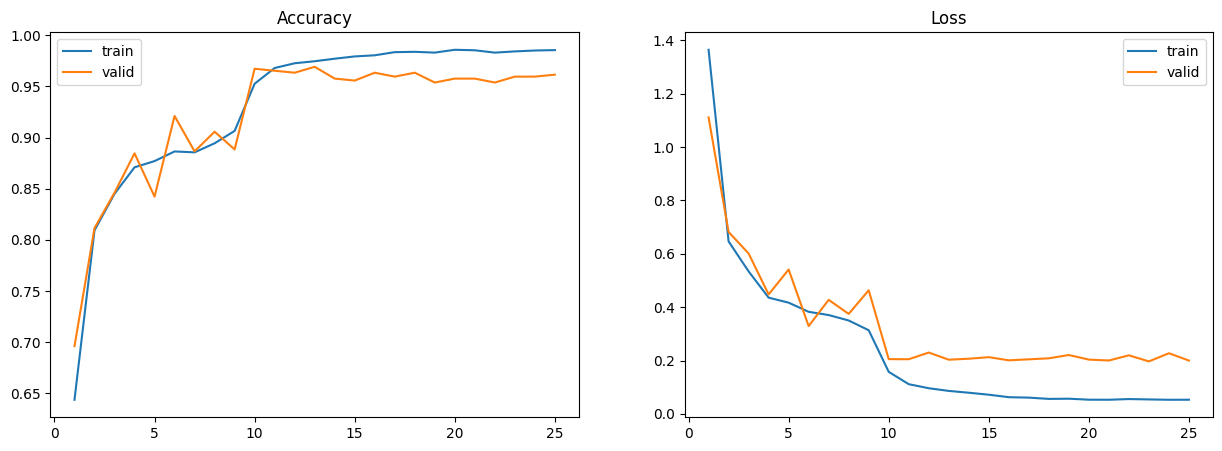

In [37]:
import seaborn as sns

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

sns.lineplot(x=range(1, len(history_acc['train'])+1), y=history_acc['train'], ax=axes[0], label='train')
sns.lineplot(x=range(1, len(history_acc['valid'])+1), y=history_acc['valid'], ax=axes[0], label='valid')
axes[0].set_title('Accuracy')

sns.lineplot(x=range(1, len(history_loss['train'])+1), y=history_loss['train'], ax=axes[1], label='train')
sns.lineplot(x=range(1, len(history_loss['valid'])+1), y=history_loss['valid'], ax=axes[1], label='valid')
axes[1].set_title('Loss')

TESTING MODEL

In [39]:
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)

In [41]:
model.eval()

test_acc = 0
with torch.inference_mode():
    for img_batch, label_batch in test_dataloader:
        img_batch, label_batch = img_batch.to(device), label_batch.to(device)
        output = model(img_batch)
        final_output = torch.argmax(torch.softmax(output, dim=1), dim=1)
        test_acc += ((final_output == label_batch).sum().item() / len(label_batch))
    test_acc = test_acc / len(test_dataloader)
    
print(f'Accuracy on test dataset: {test_acc*100:.3f}%')
        

Accuracy on test dataset: 97.500%


SAVING MODEL

In [46]:
from pathlib import Path

MODEL_PATH = Path('models')
MODEL_PATH.mkdir(parents=True, exist_ok=True)

MODEL_NAME = 'butterfly_classification.pth'

SAVE_PATH = MODEL_PATH / MODEL_NAME

SAVE_PATH

WindowsPath('models/butterfly_classification.pth')

In [47]:
print(f'Saving model to: {SAVE_PATH}')

torch.save(model.state_dict(), SAVE_PATH)

print('Model saved!')

Saving model to: models\butterfly_classification.pth
Model saved!


TESTING SAVED MODEL

In [52]:
loaded_model = resnet18()
loaded_model.fc = nn.Linear(loaded_model.fc.in_features, len(class_name))

loaded_model.load_state_dict(torch.load(SAVE_PATH, weights_only=True))

loaded_model.to(device)
loaded_model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [53]:
test_acc = 0
with torch.inference_mode():
    for img_batch, label_batch in test_dataloader:
        img_batch, label_batch = img_batch.to(device), label_batch.to(device)
        output = loaded_model(img_batch)
        final_output = torch.argmax(torch.softmax(output, dim=1), dim=1)
        test_acc += ((final_output == label_batch).sum().item() / len(label_batch))
    test_acc = test_acc / len(test_dataloader)
    
print(f'Accuracy on test dataset of loaded_model: {test_acc*100:.3f}%')

Accuracy on test dataset of loaded_model: 97.500%


THANKS FOR READING!